# STEP B

In [78]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

def read_image_and_compute_keypoints(object_imgs, scene_imgs, detector):
    imgs_dict = {}

    for name_img in object_imgs:
        img_load = cv2.imread('models/' + name_img + '.jpg', cv2.IMREAD_GRAYSCALE)
        
        """
        # Enlever le centre de l'image
        row = int(img_load.shape[0]/2)
        col = int(img_load.shape[1]/2)
        pour = 0.5
        new_color = 255 # White
        img_load[int(row - row*pour) : int(row + row*pour), int(col - col*pour): int(col + col*pour)] = new_color
        #
        """

        kp, des = detector.detectAndCompute(img_load, None)
        imgs_dict[name_img] = {'kp': kp, 'des': des, 'shape': img_load.shape}

    for name_img in scene_imgs:
        img_load = cv2.imread('scenes/' + name_img + '.png', cv2.IMREAD_GRAYSCALE)
        kp, des = detector.detectAndCompute(img_load, None)
        imgs_dict[name_img] = {'kp': kp, 'des': des, 'shape': img_load.shape}

    return imgs_dict

def matching_and_localize_objects_in_scene(imgs_dict, name_scene_img, ratio_test=0.45):
    all_scene_corners = {}
    all_good ={}
    for name in object_imgs:
        object_des, object_kp = imgs_dict[name]['des'], imgs_dict[name]['kp']
        scene_des, scene_kp = imgs_dict[name_scene_img]['des'], imgs_dict[name_scene_img]['kp']
        
        #-- matching
        matches = matcher.knnMatch(object_des, scene_des, k=2)
    
        #-- store all the good matches as per Lowe's ratio test.
        good = []
        for m,n in matches:
            if m.distance < ratio_test*n.distance:
                good.append(m)
                
        if len(good) > 30:        
            #-- Get the keypoints from the good matches
            object_good_kp = np.float32([ object_kp[m.queryIdx].pt for m in good ])
            scene_good_kp = np.float32([ scene_kp[m.trainIdx].pt for m in good ])   


            #-- Get the corners of object
            h,w = imgs_dict[name]['shape'][0:2]
            object_corners = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

            #-- Get the homography of object/scene
            H, _ =  cv2.findHomography(object_good_kp, scene_good_kp, cv2.RANSAC, 5.0)

            #-- Get the corners of object in scene
            scene_corners = cv2.perspectiveTransform(object_corners, H)


            all_scene_corners[name] = scene_corners
            all_good[name] = good
        
    return all_scene_corners, all_good

def check_best_color_matches(all_scene_corners, name_scene_img):
    
    scene_img_bgr = cv2.imread('scenes/' + name_scene_img + '.png')
    best_all_scene_corners = {}
    
    for name in all_scene_corners.keys():

        x_min = max(int(np.min(all_scene_corners[name], axis=0)[0][0]), 0)
        y_min = max(int(np.min(all_scene_corners[name], axis=0)[0][1]), 0)
        x_max = int(np.max(all_scene_corners[name], axis=0)[0][0])
        y_max = int(np.max(all_scene_corners[name], axis=0)[0][1])
        
        object_img_bgr = cv2.imread('models/' + name + '.jpg')
        
        object_img_mean_color = object_img_bgr.mean(axis=0).mean(axis=0)
        object_in_scene_img = scene_img_bgr[y_min:y_max,x_min:x_max]
        object_in_scene_img_mean_color = object_in_scene_img.mean(axis=0).mean(axis=0)   
        color_diff = np.sqrt(np.sum([value ** 2 for value in abs(object_img_mean_color - object_in_scene_img_mean_color)]))
        
        #color_diff = (np.sum([value **2 for value in (object_img_mean_color - object_in_scene_img_mean_color)]))/4
        
        if color_diff < 60:
            best_all_scene_corners[name] = all_scene_corners[name]
        
    return best_all_scene_corners

def drawn_object_lines_in_scene(img_scene, best_all_scene_corners):
    for name in best_all_scene_corners.keys():
        scene_corners = best_all_scene_corners[name]
        img_scene = cv2.polylines(img_scene, [np.int32(scene_corners)], 
                                  isClosed=True, color=(0,255,0), thickness=5)
    return img_scene

def print_object_found(best_all_scene_corners):
    for name in best_all_scene_corners.keys():  
        x_min = max(int(np.min(best_all_scene_corners[name], axis=0)[0][0]), 0)
        y_min = max(int(np.min(best_all_scene_corners[name], axis=0)[0][1]), 0)
        x_max = int(np.max(best_all_scene_corners[name], axis=0)[0][0])
        y_max = int(np.max(best_all_scene_corners[name], axis=0)[0][1])
        
        print('Product {} - {} instance/s found:'.format(name, 1))
        print('\tInstance {} position: {}, width: {}px, height: {}px'.format(1, (x_min, y_min), (x_max-x_min), (y_max-y_min)))
    
    print('_' * 80 + '\n')

def stepA():
    
    detector = cv2.SIFT_create()
    FLANN_INDEX_KDTREE = 1

        # Defining parameters for algorithm 
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

        # Defining search params.
        # checks=50 specifies the number of times the trees in the index should be recursively traversed.
        # Higher values gives better precision, but also takes more time
    search_params = dict(checks = 50)

        # Initializing matcher
    matcher = cv2.FlannBasedMatcher(index_params, search_params)
    #matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
    
    imgs_dict = read_image_and_compute_keypoints(object_imgs, scene_imgs, detector)
    
    
    for scene_name in scene_imgs:
        
        all_scene_corners, all_good= matching_and_localize_objects_in_scene(imgs_dict, scene_name)
        
        best_all_scene_corners = check_best_color_matches(all_scene_corners , scene_name)
        
        
        img_scene_rgb = cv2.cvtColor(cv2.imread('scenes/' + scene_name + '.png'), cv2.COLOR_BGR2RGB)
        img_scene_rgb = drawn_object_lines_in_scene(img_scene_rgb, best_all_scene_corners)

        
        print('Scene {} :'.format(scene_name))
        plt.imshow(img_scene_rgb)
        plt.show()
        print_object_found(best_all_scene_corners)

In [79]:
#-- bank of image step B
object_imgs = ['0', '1', '11', '19', '24', '25', '26']
#object_imgs = ['0', '11']
scene_imgs = ['m1', 'm2', 'm3', 'm4', 'm5']

detector = cv2.SIFT_create()
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
matcher = cv2.FlannBasedMatcher(index_params, search_params)

In [80]:
imgs_dict = read_image_and_compute_keypoints(object_imgs, scene_imgs, detector)

In [81]:
imgs_dict

{'0': {'kp': [<KeyPoint 0x7fb72700df60>,
   <KeyPoint 0x7fb72700df90>,
   <KeyPoint 0x7fb72711fb10>,
   <KeyPoint 0x7fb72670e450>,
   <KeyPoint 0x7fb72627cbd0>,
   <KeyPoint 0x7fb7236b8990>,
   <KeyPoint 0x7fb7251afdb0>,
   <KeyPoint 0x7fb72713dcc0>,
   <KeyPoint 0x7fb74b025e10>,
   <KeyPoint 0x7fb74b025de0>,
   <KeyPoint 0x7fb74b025c90>,
   <KeyPoint 0x7fb713d5cf60>,
   <KeyPoint 0x7fb713d5ced0>,
   <KeyPoint 0x7fb713d5cf30>,
   <KeyPoint 0x7fb727604180>,
   <KeyPoint 0x7fb727604060>,
   <KeyPoint 0x7fb7276041e0>,
   <KeyPoint 0x7fb727604120>,
   <KeyPoint 0x7fb7276041b0>,
   <KeyPoint 0x7fb713a3d390>,
   <KeyPoint 0x7fb713a3d600>,
   <KeyPoint 0x7fb713a3d030>,
   <KeyPoint 0x7fb713a3d060>,
   <KeyPoint 0x7fb713a3d0c0>,
   <KeyPoint 0x7fb713a3d120>,
   <KeyPoint 0x7fb713a3d150>,
   <KeyPoint 0x7fb713a3d0f0>,
   <KeyPoint 0x7fb713a3d1e0>,
   <KeyPoint 0x7fb713a3d240>,
   <KeyPoint 0x7fb713a3d2d0>,
   <KeyPoint 0x7fb713a3d090>,
   <KeyPoint 0x7fb713a3d270>,
   <KeyPoint 0x7fb713a3d210>,

In [122]:
#for name in object_imgs:
object_des, object_kp = imgs_dict['24']['des'], imgs_dict['24']['kp']
scene_des, scene_kp = imgs_dict['m1']['des'], imgs_dict['m1']['kp']

#-- matching
matches = matcher.knnMatch(object_des, scene_des, k=2)

#-- store all the good matches as per Lowe's ratio test.
goodIdx = {}
for m,n in matches:
    if m.distance < 0.5*n.distance:
        goodIdx[m.trainIdx] = m.queryIdx

good = []
for m,n in matches:
    if m.distance < 0.5*n.distance:
        good.append(m)

#-- barycenter of found object keypoint 
object_good_kp = [ object_kp[m.queryIdx] for m in good ]

object_xc = np.mean([ kp.pt[0] for kp in object_good_kp ], dtype='float')
object_yc = np.mean([ kp.pt[1] for kp in object_good_kp ], dtype='float')

# create hough space 
# map of hough space kp_train_idx -> map name-values
hough_space = {}

for scene_Idx, object_Idx in goodIdx.items():

    #compute_entry_hough_space(kp_q = kp_query[q_idx], kp_t = kp_train[t_idx], q_xc = query_xc, q_yc = query_yc)

    kp_q = object_kp[object_Idx]
    kp_t = scene_kp[scene_Idx]
    q_xc = object_xc
    q_yc = object_yc

    entry = {}

    v = ((q_xc - kp_q.pt[0]), (q_yc - kp_q.pt[1]))
    scale_ratio = kp_t.size / kp_q.size
    delta_angle = kp_t.angle - kp_q.angle
    x_c = kp_t.pt[0] + scale_ratio * (np.cos(delta_angle) * v[0] - np.sin(delta_angle) * v[1])
    y_c = kp_t.pt[1] + scale_ratio * (np.sin(delta_angle) * v[0] + np.cos(delta_angle) * v[1])

    entry['x_c'] = x_c
    entry['y_c'] = y_c
    entry['scale_ratio'] = scale_ratio
    entry['delta_angle'] = delta_angle

    hough_space[scene_Idx] = entry

#hough_space[t_idx] = entry
        
        
        

In [123]:
entry

{'x_c': 1199.589785399645,
 'y_c': 201.70602005136942,
 'scale_ratio': 1.3863444711983242,
 'delta_angle': -319.1788635253906}

In [124]:
hough_space

{842: {'x_c': 355.09983900855013,
  'y_c': 317.1400952841467,
  'scale_ratio': 1.1341718671903613,
  'delta_angle': 1.088531494140625},
 863: {'x_c': 218.39991318644581,
  'y_c': 138.7885576856777,
  'scale_ratio': 1.2904142893616906,
  'delta_angle': -3.93072509765625},
 103: {'x_c': 110.06145706150915,
  'y_c': -66.0442635107637,
  'scale_ratio': 1.4659271088418622,
  'delta_angle': -2.2049102783203125},
 138: {'x_c': 22.880257828265222,
  'y_c': 266.70366316809293,
  'scale_ratio': 1.13764346169738,
  'delta_angle': -7.4033203125},
 918: {'x_c': 557.7258041790946,
  'y_c': 254.38984119554937,
  'scale_ratio': 1.158615381083558,
  'delta_angle': -0.297210693359375},
 161: {'x_c': 130.01047779770624,
  'y_c': 327.5777908322375,
  'scale_ratio': 1.3778044655138852,
  'delta_angle': 0.444091796875},
 173: {'x_c': 247.97884551026797,
  'y_c': 65.34359430979276,
  'scale_ratio': 1.2273231926230848,
  'delta_angle': 4.919921875},
 176: {'x_c': 251.57164572331064,
  'y_c': 239.1335046223261

In [125]:
object_xc

142.24710319353187

In [126]:
goodIdx.items()

dict_items([(842, 30), (863, 45), (103, 92), (138, 101), (918, 129), (161, 142), (173, 152), (176, 161), (181, 170), (188, 171), (202, 173), (952, 199), (231, 212), (229, 210), (230, 211), (245, 220), (237, 228), (989, 271), (990, 272), (988, 274), (994, 280), (274, 288), (275, 289), (1006, 291), (1021, 323), (1023, 334), (1025, 335), (1029, 337), (1027, 342), (1028, 343), (1032, 353), (1039, 354), (346, 382), (348, 396), (1064, 400), (366, 401), (1067, 404), (374, 416), (1079, 419), (1086, 422), (382, 424), (1094, 428), (390, 449), (384, 462), (393, 466), (403, 473), (396, 483), (1123, 484), (427, 515), (435, 523), (1152, 530), (452, 535), (437, 543), (458, 544), (1169, 546), (457, 548), (1173, 565), (1188, 576), (466, 581), (1196, 606), (488, 611), (1207, 616), (1208, 617), (1211, 619), (1217, 633), (1233, 647), (527, 651), (1229, 653), (535, 662), (536, 663), (1247, 678), (556, 691), (557, 697), (585, 759), (1318, 762), (1329, 797), (632, 802), (633, 803), (649, 808), (1357, 823), (

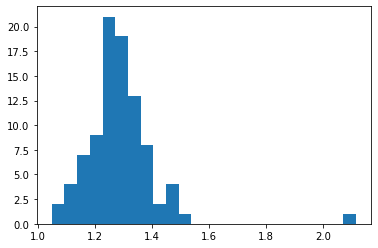

In [127]:
#compute_bins(hough_space,query_shape,train_shape):

values = {}

data_scale = [entry['scale_ratio'] for entry in hough_space.values()]
counts_scale, bins_scale, patches_size = plt.hist(data_scale, bins='auto')
img_scale = np.mean([bins_scale[np.argmax(counts_scale)], bins_scale[np.argmax(counts_scale) + 1]])
#plt.close();

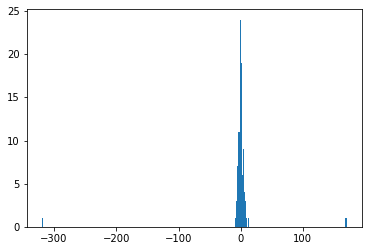

In [128]:
data_angle = [entry['delta_angle'] for entry in hough_space.values()]
counts_angle, bins_angle, patches_angle = plt.hist(data_angle, bins='auto')
#plt.close();

In [129]:
BIN_PRECISION_FACTOR = 0.25
ANGLE_BINS = 7
ANGLE_BIN_SIZE_COEFF = 0.1
SCALE_BIN_SIZE_COEFF = 0.1

query_shape = imgs_dict['24']['shape']
train_shape = imgs_dict['m1']['shape']

x_bin_size = img_scale * query_shape[1] * BIN_PRECISION_FACTOR
y_bin_size = img_scale * query_shape[0] * BIN_PRECISION_FACTOR
x_bins = int(np.ceil(train_shape[1] / x_bin_size) + 2)
y_bins = int(np.ceil(train_shape[0] / y_bin_size) + 2)
x_min = train_shape[1] / 2 - x_bins / 2 * x_bin_size
y_min = train_shape[0] / 2 - y_bins / 2 * y_bin_size

angle_bin_size = np.std(data_angle) * ANGLE_BIN_SIZE_COEFF
angle_bin_center = np.mean(data_angle)
angle_min = angle_bin_center - ANGLE_BINS / 2 * angle_bin_size
angle_max = angle_bin_center + ANGLE_BINS / 2 * angle_bin_size

scale_bin_size = np.std(data_scale) * SCALE_BIN_SIZE_COEFF
scale_bin_center = np.mean(data_scale)
scale_min = 0 
scale_max = scale_bin_center * 2 
scale_bins = int((scale_max - scale_min) / scale_bin_size)

bins_values = {}
bins_values['x_bins'] = x_bins
bins_values['y_bins'] = y_bins
bins_values['x_min'] = x_min
bins_values['y_min'] = y_min
bins_values['x_bin_size'] = x_bin_size
bins_values['y_bin_size'] = y_bin_size
bins_values['scale_bins'] = scale_bins
bins_values['scale_min'] = scale_min
bins_values['scale_bin_size'] = scale_bin_size
bins_values['angle_min'] = angle_min
bins_values['angle_bin_size'] = angle_bin_size  

    #return values

In [130]:
bins_values

{'x_bins': 19,
 'y_bins': 6,
 'x_min': -89.30532271485606,
 'y_min': -129.19609343935588,
 'x_bin_size': 84.34792870682695,
 'y_bin_size': 120.89869781311862,
 'scale_bins': 209,
 'scale_min': 0,
 'scale_bin_size': 0.012327700422739053,
 'angle_min': -14.775403093433473,
 'angle_bin_size': 3.8042562468066397}

In [131]:
accumulator = np.zeros((bins_values['x_bins'], bins_values['y_bins'], ANGLE_BINS, bins_values['scale_bins']))

votes = {}

for idx, v in hough_space.items():
    try:
        for x in range(0, 2):
            for y in range(0, 2):
                for z in range(0, 2):
                    for w in range(0, 2):                
                        i = int(np.floor((v['x_c'] - bins_values['x_min'] + (x - 1 / 2) * bins_values['x_bin_size']) / bins_values['x_bin_size']))
                        j = int(np.floor((v['y_c'] - bins_values['y_min'] + (y - 1 / 2) * bins_values['y_bin_size']) / bins_values['y_bin_size']))
                        k = int(np.floor((v['delta_angle'] - bins_values['angle_min'] + (z - 1 / 2) * bins_values['angle_bin_size']) / bins_values['angle_bin_size']))
                        l = int(np.floor((v['scale_ratio'] - bins_values['scale_min'] + (w - 1 / 2) * bins_values['scale_bin_size']) / bins_values['scale_bin_size']))
                        if i >= 0 and j >= 0 and k >= 0 and l >= 0:
                            accumulator[i, j, k, l] += 1
                            votes[(i, j, k, l)] = votes.get((i, j, k, l), [])
                            votes[(i, j, k, l)].append(idx)
    except: pass

In [132]:
votes

{(4, 3, 3, 91): [842],
 (4, 3, 3, 92): [842],
 (4, 3, 4, 91): [842],
 (4, 3, 4, 92): [842],
 (4, 4, 3, 91): [842],
 (4, 4, 3, 92): [842],
 (4, 4, 4, 91): [842],
 (4, 4, 4, 92): [842],
 (5, 3, 3, 91): [842],
 (5, 3, 3, 92): [842],
 (5, 3, 4, 91): [842],
 (5, 3, 4, 92): [842],
 (5, 4, 3, 91): [842],
 (5, 4, 3, 92): [842],
 (5, 4, 4, 91): [842],
 (5, 4, 4, 92): [842],
 (3, 1, 2, 104): [863],
 (3, 1, 2, 105): [863],
 (3, 1, 3, 104): [863],
 (3, 1, 3, 105): [863],
 (3, 2, 2, 104): [863],
 (3, 2, 2, 105): [863],
 (3, 2, 3, 104): [863, 348],
 (3, 2, 3, 105): [863],
 (4, 1, 2, 104): [863],
 (4, 1, 2, 105): [863],
 (4, 1, 3, 104): [863],
 (4, 1, 3, 105): [863],
 (4, 2, 2, 104): [863],
 (4, 2, 2, 105): [863],
 (4, 2, 3, 104): [863, 348],
 (4, 2, 3, 105): [863],
 (1, 0, 2, 118): [103],
 (1, 0, 2, 119): [103],
 (1, 0, 3, 118): [103],
 (1, 0, 3, 119): [103],
 (1, 1, 2, 118): [103],
 (1, 1, 2, 119): [103],
 (1, 1, 3, 118): [103],
 (1, 1, 3, 119): [103],
 (2, 0, 2, 118): [103],
 (2, 0, 2, 119): [103]

In [133]:
accumulator

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 

In [134]:
import skimage.morphology as sk

In [135]:
mask = sk.local_maxima(accumulator)

In [136]:
mask.shape

(19, 6, 7, 209)

In [137]:
accumulator[mask != 1] = 0

In [144]:
T_Q = 5
global_correspondences = []

for b in list(np.argwhere(accumulator >= T_Q)): # thresholding the accumulator to come up with few maxima 
    keypoint_index_list = votes[tuple(b)] # all query keypoint who voted for a local maxima bin 
    correspondence_list = [(scene_kp[k], object_kp[goodIdx[k]]) for k in keypoint_index_list]
    global_correspondences.append([accumulator[tuple(b)], '24', correspondence_list])

In [145]:
np.argwhere(accumulator >= T_Q)

array([[  7,   3,   3, 102],
       [  7,   3,   4, 102]])

In [146]:
global_correspondences

[[8.0,
  '24',
  [(<KeyPoint 0x7fb713ba4120>, <KeyPoint 0x7fb7138c3ea0>),
   (<KeyPoint 0x7fb713ba47b0>, <KeyPoint 0x7fb7138c4a20>),
   (<KeyPoint 0x7fb713ba4f60>, <KeyPoint 0x7fb7138c56c0>),
   (<KeyPoint 0x7fb713ba6450>, <KeyPoint 0x7fb7138c7630>),
   (<KeyPoint 0x7fb713ba6720>, <KeyPoint 0x7fb7138c7840>),
   (<KeyPoint 0x7fb713ba68a0>, <KeyPoint 0x7fb7138c7de0>),
   (<KeyPoint 0x7fb713ba6b70>, <KeyPoint 0x7fb7138c8090>),
   (<KeyPoint 0x7fb713ba6f90>, <KeyPoint 0x7fb7138c85d0>)]],
 [8.0,
  '24',
  [(<KeyPoint 0x7fb713ba4120>, <KeyPoint 0x7fb7138c3ea0>),
   (<KeyPoint 0x7fb713ba47b0>, <KeyPoint 0x7fb7138c4a20>),
   (<KeyPoint 0x7fb713ba4f60>, <KeyPoint 0x7fb7138c56c0>),
   (<KeyPoint 0x7fb713ba6450>, <KeyPoint 0x7fb7138c7630>),
   (<KeyPoint 0x7fb713ba6720>, <KeyPoint 0x7fb7138c7840>),
   (<KeyPoint 0x7fb713ba68a0>, <KeyPoint 0x7fb7138c7de0>),
   (<KeyPoint 0x7fb713ba6b70>, <KeyPoint 0x7fb7138c8090>),
   (<KeyPoint 0x7fb713ba6f90>, <KeyPoint 0x7fb7138c85d0>)]]]

In [156]:
h,w = imgs_dict['24']['shape'][0:2]
object_corners = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

entry = global_correspondences[1]
src_pts = np.float32([e[1].pt for e in entry[2]]).reshape(-1, 1, 2)
dst_pts = np.float32([e[0].pt for e in entry[2]]).reshape(-1, 1, 2)
H, _ =  cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)


scene_corners = cv2.perspectiveTransform(object_corners, H)

In [157]:
entry

[8.0,
 '24',
 [(<KeyPoint 0x7fb713ba4120>, <KeyPoint 0x7fb7138c3ea0>),
  (<KeyPoint 0x7fb713ba47b0>, <KeyPoint 0x7fb7138c4a20>),
  (<KeyPoint 0x7fb713ba4f60>, <KeyPoint 0x7fb7138c56c0>),
  (<KeyPoint 0x7fb713ba6450>, <KeyPoint 0x7fb7138c7630>),
  (<KeyPoint 0x7fb713ba6720>, <KeyPoint 0x7fb7138c7840>),
  (<KeyPoint 0x7fb713ba68a0>, <KeyPoint 0x7fb7138c7de0>),
  (<KeyPoint 0x7fb713ba6b70>, <KeyPoint 0x7fb7138c8090>),
  (<KeyPoint 0x7fb713ba6f90>, <KeyPoint 0x7fb7138c85d0>)]]

In [158]:
scene_corners

array([[[383.96997 , -12.431214]],

       [[391.26663 , 457.54916 ]],

       [[726.7153  , 469.0294  ]],

       [[722.96246 , -36.735184]]], dtype=float32)

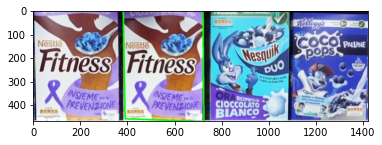

In [159]:
img_scene = cv2.imread('scenes/m1.png')
img_scene = cv2.polylines(img_scene, [np.int32(scene_corners)], isClosed=True, color=(0,255,0), thickness=5)
plt.imshow(img_scene)